# 🧭 Phrasely Evaluation & Visualization Notebook
### This notebook summarizes clustering quality, structure, and representative examples for the Phrasely pipeline (embeddings → SVD → UMAP → HDBSCAN).

### Phase 1: Loading data, embedding it, reducing it, generating clusters, all in GPU (if you have it)

In [1]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
from pathlib import Path
import os

from phrasely.data_loading.csv_loader import CSVLoader
from phrasely.embeddings.phrase_embedder import PhraseEmbedder
from phrasely.reduction.svd_reducer import SVDReducer
from phrasely.clustering.hdbscan_clusterer import HDBSCANClusterer
from phrasely.medoids.medoid_selector import MedoidSelector
from phrasely.evaluation import ClusterEvaluator
from phrasely.reduction.visualization_reducer import UMAPReducer

logging.basicConfig(level=logging.INFO, format="%(message)s")

/home/michael/micromamba/envs/phrasely-gpu/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
loader = CSVLoader(input_path="../data/msmarco.csv")
phrases = loader.load()
print(f"Loaded {len(phrases)} phrases.")

Loaded 941161 phrases.


In [3]:
from phrasely.embeddings.phrase_embedder import PhraseEmbedder

embedder = PhraseEmbedder(batch_size=8)
embeddings = embedder.embed(phrases, dataset_name="msmarco_full")
print("Embeddings:", embeddings.shape)

PhraseEmbedder using model=sentence-transformers/all-MiniLM-L6-v2, device=cuda, batch_size=8
Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
Converted model to fp16 for reduced VRAM usage.
🔁 Loading cached embeddings for 'msmarco_full' from data_cache/embeddings_msmarco_full_sentence-transformers-all-MiniLM-L6-v2.npy


Embeddings: (941161, 384)


In [4]:
sample_idx = np.random.choice(len(embeddings), size=100_000, replace=False)
embeddings_sample = embeddings[sample_idx]
phrases_sample = [phrases[i] for i in sample_idx]

In [5]:
from phrasely.reduction.two_stage_reducer import TwoStageReducer

reducer = TwoStageReducer(
    svd_components=256,
    umap_components=10,
    n_neighbors=15,
    min_dist=0.0,
    metric="cosine",
    use_gpu=True,
)

reduced_two_stage = reducer.reduce(embeddings_sample)
print(f"Output shape: {reduced_two_stage.shape}")

HybridReducer: input shape=(100000, 384), GPU=True, VRAM≈3.8 GB
Converting input from float16 to float32 for GPU compatibility.
Stage 1 (GPU SVD): reduced 384 → 256 dims
Stage 2 (GPU UMAP): reduced 256 → 10 dims


Output shape: (100000, 10)


In [6]:
from phrasely.clustering.hdbscan_clusterer import HDBSCANClusterer
import numpy as np

clusterer = HDBSCANClusterer(min_cluster_size=10, min_samples=3, use_gpu=True)
labels = clusterer.cluster(reduced_two_stage)

unique, counts = np.unique(labels, return_counts=True)
n_clusters = len(unique) - (1 if -1 in unique else 0)
n_noise = counts[unique == -1][0] if -1 in unique else 0

print(f"Found {n_clusters} clusters, with {n_noise} noise points.")

HDBSCANClusterer initialized with GPU backend.
HDBSCANClusterer: using GPU backend.
Running cuML HDBSCAN on GPU...
HDBSCANClusterer: found 2439 clusters (+ noise).


Found 2439 clusters, with 37657 noise points.


In [7]:
viz_reducer = UMAPReducer(n_components=2, use_gpu=True)
points_2d = viz_reducer.reduce(reduced_two_stage)

UMAPReducer initialized with GPU backend.
Running cuML UMAP on GPU...
UMAPReducer: reduced to 2 dimensions.


In [36]:
from phrasely.evaluation.dbcv_score import compute_dbcv
mask = labels != -1
score = compute_dbcv(reduced_two_stage[mask], labels[mask])
score

DBCV: subsampled 5000/62144 points.


0.6432278813772941

# 🧭 Phrasely Evaluation & Visualization

## 1. Summary Metrics

In [9]:

from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from phrasely.medoids.medoid_selector import MedoidSelector
from phrasely.evaluation.dbcv_score import compute_dbcv

mask = labels != -1
X_valid, y_valid = reduced_two_stage[mask], labels[mask]

silhouette = None
try:
    sample_idx = np.random.choice(len(X_valid), size=5000, replace=False)
    silhouette = silhouette_score(X_valid[sample_idx], y_valid[sample_idx])
except Exception as e:
    print(f"Silhouette skipped: {e}")

ch = calinski_harabasz_score(X_valid, y_valid)
db = davies_bouldin_score(X_valid, y_valid)
dbcv = compute_dbcv(X_valid, y_valid)

print(f"Silhouette: {silhouette:.3f}" if silhouette else "Silhouette: N/A")
print(f"Calinski–Harabasz: {ch:.1f}")
print(f"Davies–Bouldin: {db:.3f}")
print(f"DBCV: {dbcv:.3f}")


DBCV: subsampled 5000/62343 points.


Silhouette: 0.423
Calinski–Harabasz: 8627.4
Davies–Bouldin: 0.728
DBCV: 0.653


## 2. UMAP Visualization

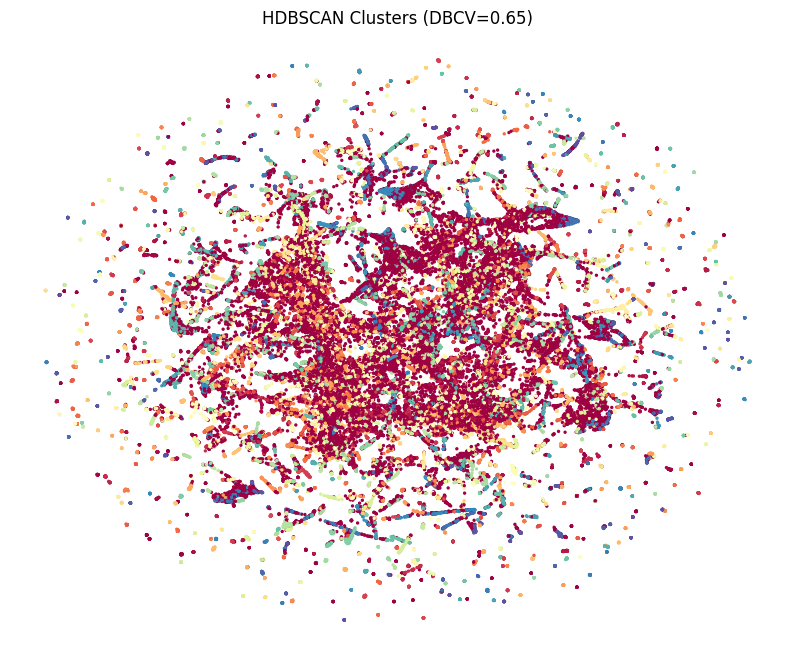

In [10]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.scatter(points_2d[:, 0], points_2d[:, 1], c=labels, s=2, cmap="Spectral")
plt.title(f"HDBSCAN Clusters (DBCV={dbcv:.2f})")
plt.axis("off")
plt.show()


## 3. Cluster Size Distribution

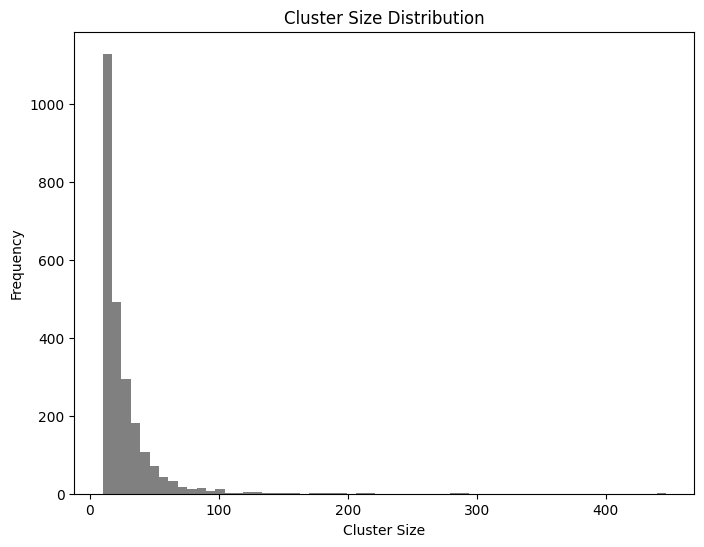

Total clusters: 2439
Noise points: 37657


In [11]:

unique, counts = np.unique(labels, return_counts=True)
cluster_sizes = counts[unique != -1]

plt.figure(figsize=(8,6))
plt.hist(cluster_sizes, bins=60, color="gray")
plt.title("Cluster Size Distribution")
plt.xlabel("Cluster Size")
plt.ylabel("Frequency")
plt.show()

print(f"Total clusters: {len(cluster_sizes)}")
print(f"Noise points: {counts[unique == -1][0] if -1 in unique else 0}")


## 4. Medoid Phrase Inspection

In [15]:

selector = MedoidSelector()
medoids = selector.select(phrases, reduced_two_stage, labels)

print("Sample medoid phrases:")
for i, m in enumerate(medoids[:15]):
    print(f"{i:3d}: {m}")


Selected 2439 medoids across 2439 clusters.


Sample medoid phrases:
  0: how much botox cost for hands
  1: how to edit a balance sheet in quickbooks
  2: in dogs what does an increase bun mean
  3: do brothers and sisters have the same dna make up
  4: what is agriculture one about
  5: when did the titanic sail
  6: homo habilis definition
  7: cost of helix bridge
  8: define: isokinetic
  9: what is a stratovolcano
 10: where is tsunami are likely to occur in u.s.
 11: food pantry definition
 12: what year is a diamond anniversary
 13: what is considered an internal fixation device
 14: how do i confirm the date i changed my name


## 5. Cohesion / Separation Diagnostics (Optional)

In [13]:

from sklearn.metrics import pairwise_distances

mask = labels != -1
X_sub, y_sub = X_valid[:5000], y_valid[:5000]  # sample for speed
D = pairwise_distances(X_sub)

intra = np.mean([D[y_sub == c][:, y_sub == c].mean() for c in np.unique(y_sub)])
inter = np.mean([D[y_sub == c][:, y_sub != c].mean() for c in np.unique(y_sub)])
print(f"Intra-cluster mean distance: {intra:.3f}")
print(f"Inter-cluster mean distance: {inter:.3f}")
print(f"Separation ratio (inter/intra): {inter/intra:.2f}")


Intra-cluster mean distance: 0.058
Inter-cluster mean distance: 3.176
Separation ratio (inter/intra): 54.50


/tmp/ipykernel_83909/1329791874.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = plt.scatter(cohesions, separations, s=np.sqrt(sizes), alpha=0.6, cmap='viridis')


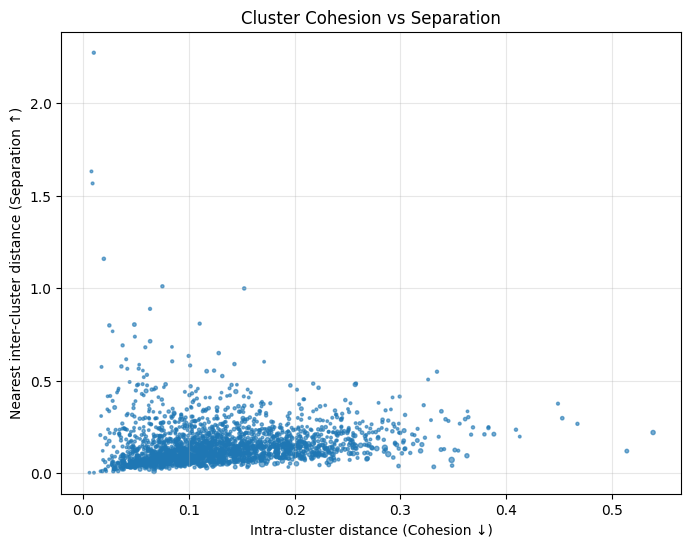

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

mask = labels != -1
X, y = reduced_two_stage[mask], labels[mask]
unique_labels = np.unique(y)

cohesions, separations, sizes = [], [], []

D = pairwise_distances(X)

for c in unique_labels:
    idx = np.where(y == c)[0]
    if len(idx) < 5:
        continue
    intra = D[np.ix_(idx, idx)].mean()
    others = np.where(y != c)[0]
    inter = D[np.ix_(idx, others)].min()
    cohesions.append(intra)
    separations.append(inter)
    sizes.append(len(idx))

plt.figure(figsize=(8,6))
sc = plt.scatter(cohesions, separations, s=np.sqrt(sizes), alpha=0.6, cmap='viridis')
plt.xlabel("Intra-cluster distance (Cohesion ↓)")
plt.ylabel("Nearest inter-cluster distance (Separation ↑)")
plt.title("Cluster Cohesion vs Separation")
plt.grid(True, alpha=0.3)
plt.show()

## 6. Save Results

In [19]:
import pandas as pd

df = pd.DataFrame({
    "phrase": phrases_sample,
    "label": labels
})
df.to_parquet("data/cluster_results.parquet", index=False)
print("✅ Saved cluster results to cluster_results.parquet")



✅ Saved cluster results to cluster_results.parquet
